In [1]:
# importando as bibliotecas necessárias
import os
import tarfile
import numpy as np
import urllib
import joblib
import pandas as pd
import seaborn as sns
import matplotlib as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("..\\datasets", "housing")

In [3]:
# url do github
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("..\\datasets", "housing")
#url + caminho do arquivo
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
#função baixar o aruivo, criar caminho local e descompactar 
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
#função para ler o data set hounsing 
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)    
    
    
    

In [4]:
#baixando, criando e descompactando base de dados
fetch_housing_data()

In [5]:
#atribuindo o df a variável housing
housing = load_housing_data()

In [6]:
# para visualizar o dataframe completo quando for de muitas colunas e linhas
'''
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)
'''

housing.head(10) # visualizando primeiras 10 linhas do dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [7]:
# total de linhas x colunas do dataframe
housing.shape

(20640, 10)

In [8]:
# resumo do df
housing.info() 
# 1 atributo categórico e 1 atributo com dados nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
# verificando quais e quantas categorias existem na variável categórica ocean_proximity
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
'''
Podemos observar atibutos com baixa e alta variabilidade verificando os valores mínimos e máximos.
Observamos os percentis para identificar como estão distribuídos as observações.
'''
housing.describe()  # resumo estatístico do df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


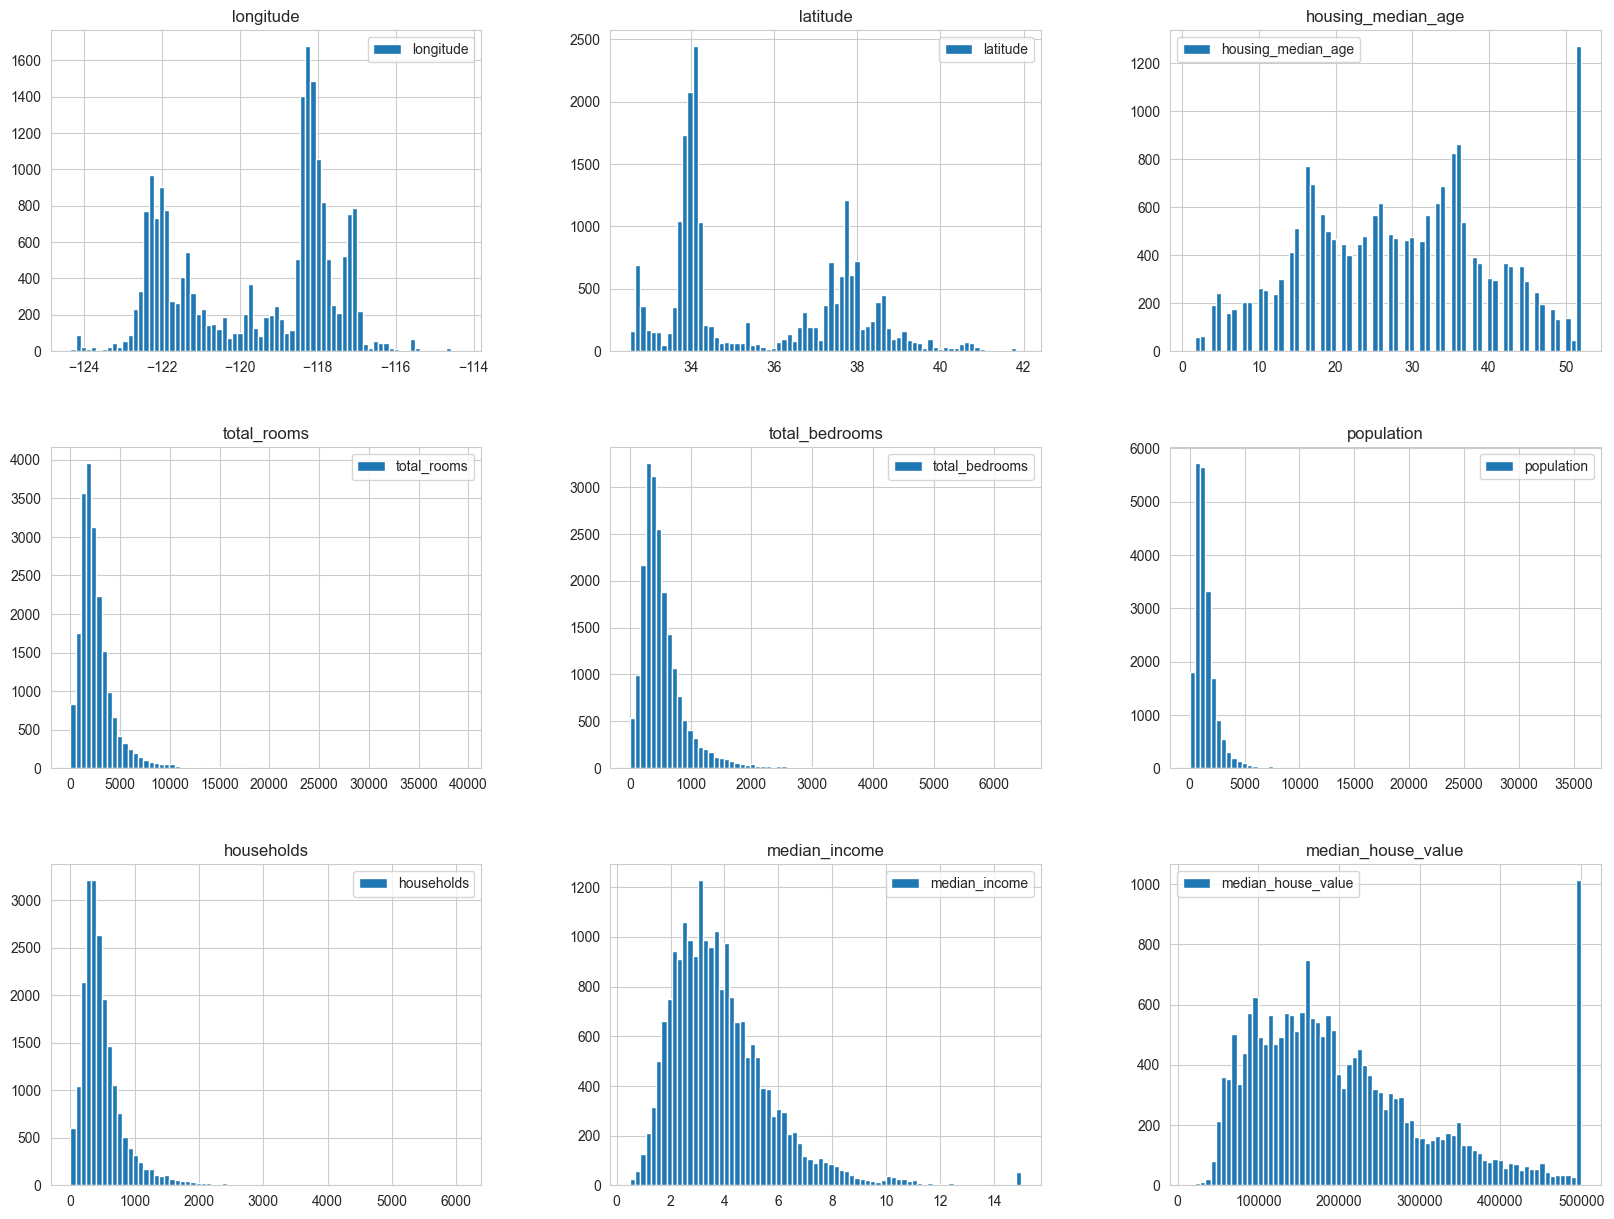

In [11]:
# verificando histograma das variáveis

'''
Temos mais de 1200 observações com valor 52
Temos mais de 1000 observações com valor acima de 500.000
obs: cuidado com o número de bins, pois pode confundir a análise visual.
'''
import matplotlib.pyplot as plt
%matplotlib inline
housing.hist(bins=75, figsize=(20, 15), legend=True);

In [12]:
'''
Separando o dataframe em conjunto de treino e teste com 20% para treino usando sklearn.
Usando random_state=42 sempre que executarmos teremos o mesmo conjunto de treino e o mesmo de teste 
'''

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
# Verificando tamanho dos conjuntos de treino e teste respectivamente
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

In [14]:
'''
Criando um atributo categórico de renda com cinco categorias rotuladas de 1 a 5
sendo que a categoria 1 varia de 0 a 1,5(US$ 15.000) 
categoria 2 de 1,5 a 3(US$ 30.000) e assim por diante.
Visto que queremos ter a mesma proporção de amostragem no treino e teste
entre as categorias de median_income" afim de evitar viés de amostragem
Buscamos uma AMOSTRAGEM ESTRATIFICADA!
'''
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

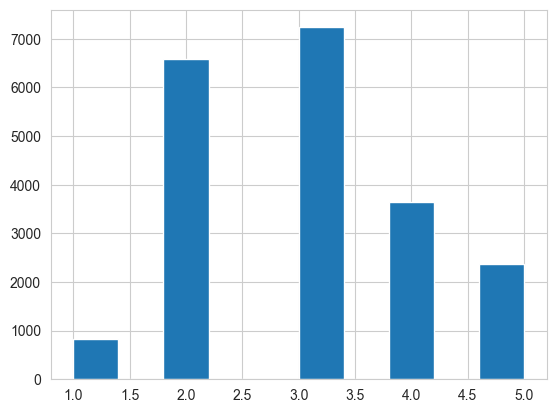

In [15]:
housing["income_cat"].hist()


In [16]:
'''
Criando conjunto de treino e teste com amostras estratificadas mantendo a 
mesma proporção de median_income" do conjunto de dados completo
'''
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [18]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [19]:
'''
Funçao para comparar as proporções das categorias no df geral, teste aleatório e
teste estratificado
'''

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({"Overall": income_cat_proportions(housing),
                              "Stratified": income_cat_proportions(strat_test_set),
                              "Random": income_cat_proportions(test_set), }).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [20]:
'''
Comparando a proporção do conjunto completo, aleátorio eo estratificado
de acordo com as categorias de renda mediana
'''
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [21]:
'''
Após ter gerado o conjunto de treino e teste estratificado
vamos remover o atributo criado para separar por categoria
'''

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
#Copiando conjunto de teste estratificado para variável housing
housing = strat_train_set.copy()

#  EDA

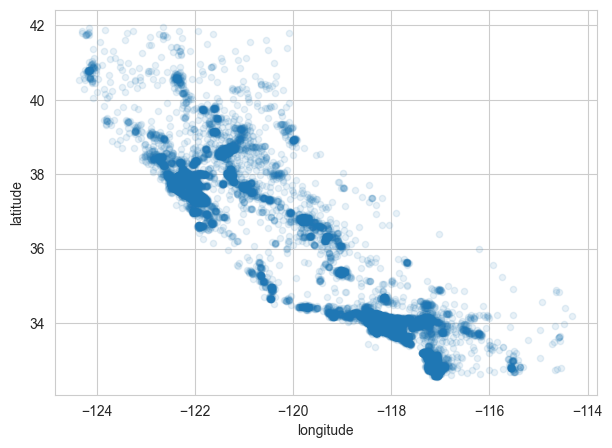

In [23]:
# Locais com maior densidade de observações 
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(7,5), alpha=0.1);

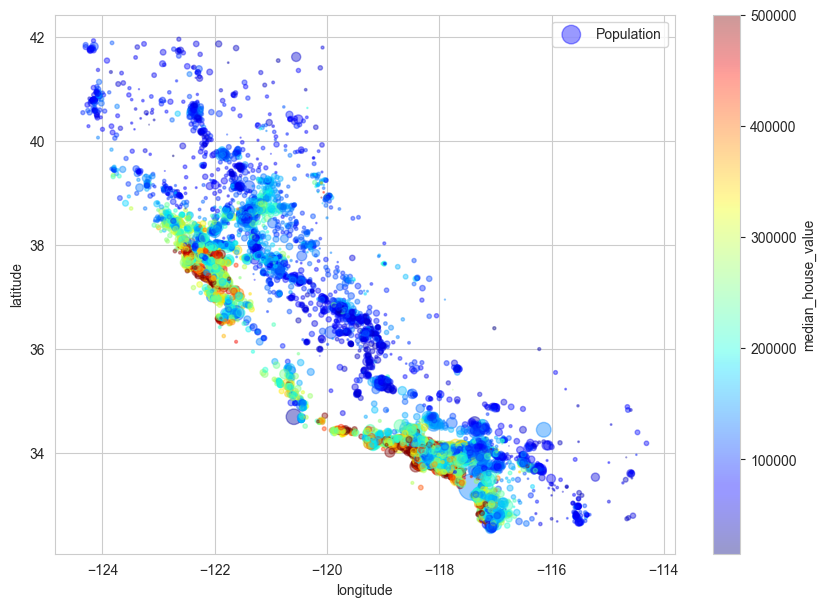

In [24]:
# Locais com maior densidade de observações, population e median_house_value
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [25]:
# Correlação entre todos os atributos
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [26]:
# Correlação com o target em ordem decrescente
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

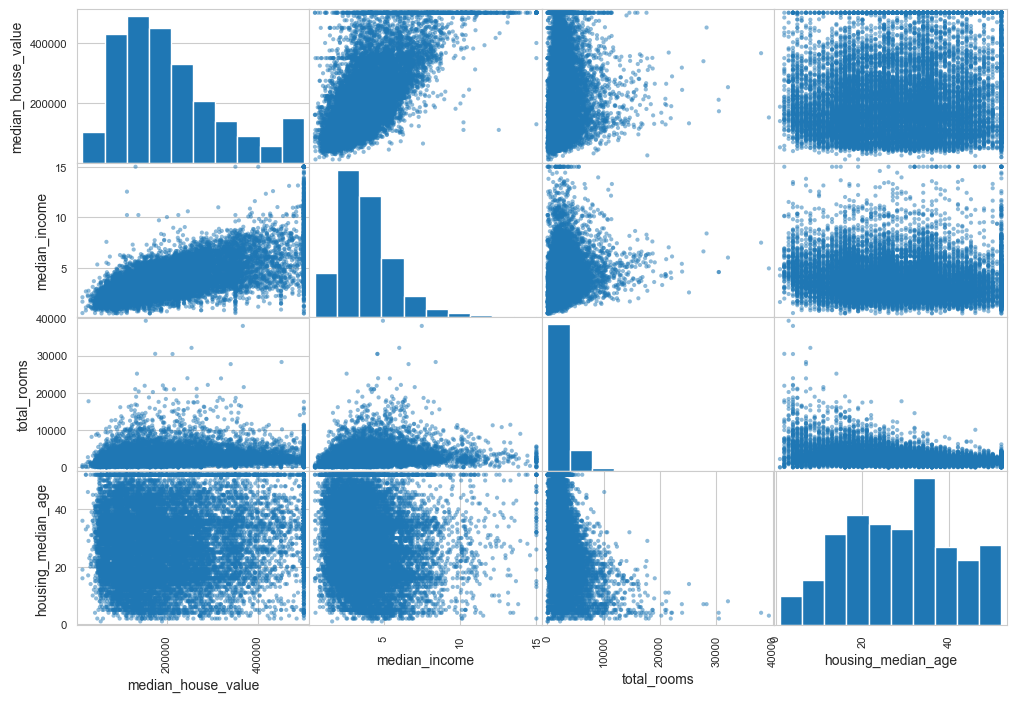

In [27]:
#scatter_matrix(housing, figsize=(10,12));
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8),diagonal='hist');


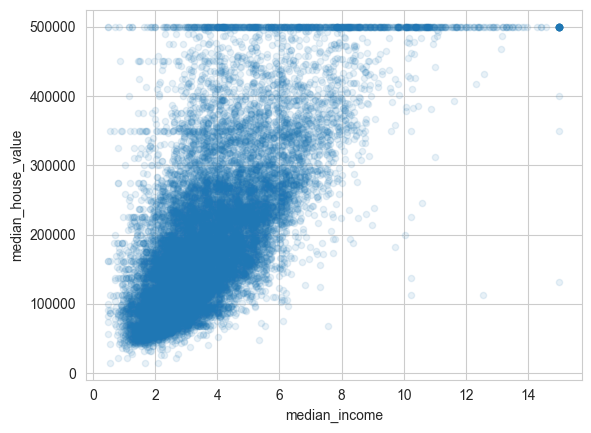

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1);

In [29]:
#Combinando atributos buscando ter uma correlação maior com target
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
# Correlação com o target em ordem decrescente com os novos atributos criados
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [31]:
#Voltando para o df limpo, sem alterações separando o target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [32]:
#housing.dropna(subset=["total_bedrooms"])    # option 1
#housing.drop("total_bedrooms", axis=1)       # option 2
#median = housing["total_bedrooms"].median()  # option 3
#housing["total_bedrooms"].fillna(median, inplace=True)

In [33]:
# Criando uma instância com a estratégia mediana para substituição dos valores numéricos ausentes
imputer = SimpleImputer(strategy="median")
# Retirando atrbuto categórico
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [34]:
# Observando os valores enocntrados da mediana dos atributos
imputer.statistics_
# housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [35]:
# Substituindo os valores ausentes pela mediana no conjunto de treino, result -> NumPy
X = imputer.transform(housing_num)

In [36]:
# Transformando a saída transformada sem dados ausentes para dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [37]:
# Verificando o dataframe
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [38]:
# Tratando atributo categórico
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
...,...
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN


In [39]:
''' Instanciando OrdinalEncoder e transformando as categorias em valores de 0 a 4,
porém este não é a técnica para o caso pois estaremos dando uma ordem de importância
'''
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
''' Instanciando OneHotEncoder e transformando as categorias em valores de 0 e 1
'''
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Falta Comentar

In [41]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [42]:
 cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [44]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()
        )])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [45]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [46]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [48]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [49]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [50]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


In [51]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [53]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [54]:
display_scores(tree_rmse_scores)

Scores: [72134.0990151  69376.73183436 69264.73558605 71248.70562234
 69272.73948775 78162.23518901 73103.49984487 74490.00125533
 67937.53408219 70716.32212876]
Mean: 71570.66040457677
Standard deviation: 2899.7013119444055


In [55]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [56]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18658.75334867434

In [57]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51343.14972517 48831.39534824 46670.63065072 51563.13577408
 47265.40429412 52015.86167587 52263.99937311 50505.87372758
 48811.46986858 54115.94222317]
Mean: 50338.68626606532
Standard deviation: 2254.497626493519


## Ajuste de hiperparâmetros

In [58]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 
               'max_features': [2, 3, 4]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,verbose=0,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [59]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [61]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62708.69156225295 {'max_features': 2, 'n_estimators': 3}
55505.44746480374 {'max_features': 2, 'n_estimators': 10}
52715.70037501289 {'max_features': 2, 'n_estimators': 30}
60583.3239437113 {'max_features': 4, 'n_estimators': 3}
53278.40386628923 {'max_features': 4, 'n_estimators': 10}
50330.926729261235 {'max_features': 4, 'n_estimators': 30}
59125.81129131013 {'max_features': 8, 'n_estimators': 3}
51934.07595708328 {'max_features': 8, 'n_estimators': 10}
49977.75210094319 {'max_features': 8, 'n_estimators': 30}
62956.06202978329 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54576.16452502125 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60374.5489767028 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52634.240256343124 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58554.87383569609 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51072.92070171632 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.19439526e-02, 6.45967924e-02, 4.37560048e-02, 1.58127468e-02,
       1.47206192e-02, 1.44626536e-02, 1.48983921e-02, 3.67164697e-01,
       3.25807758e-02, 1.11838705e-01, 7.77099722e-02, 5.16145774e-03,
       1.59619392e-01, 4.42143038e-05, 2.41886341e-03, 3.27076011e-03])

In [63]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3671646972695299, 'median_income'),
 (0.159619392216809, 'INLAND'),
 (0.11183870542987195, 'pop_per_hhold'),
 (0.07770997220007884, 'bedrooms_per_room'),
 (0.07194395258565488, 'longitude'),
 (0.06459679237422704, 'latitude'),
 (0.043756004788224355, 'housing_median_age'),
 (0.03258077578154237, 'rooms_per_hhold'),
 (0.01581274684957313, 'total_rooms'),
 (0.014898392088677985, 'households'),
 (0.01472061923856329, 'total_bedrooms'),
 (0.014462653602662887, 'population'),
 (0.005161457742354778, '<1H OCEAN'),
 (0.0032707601145130433, 'NEAR OCEAN'),
 (0.0024188634138712414, 'NEAR BAY'),
 (4.421430384538504e-05, 'ISLAND')]

In [64]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 47,730.2

In [65]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46162.82631636, 50066.93140351])